In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns


Read the data
===========

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


x_original['max']=np.min(x_original[['FIELD_6','FIELD_7']],axis=1)
x_original=x_original.drop(columns=['FIELD_6','FIELD_7'])
x_original=x_original.query('FIELD_16 != 1 and FIELD_23 != 1')

y_original['max']=np.min(y_original[['FIELD_6','FIELD_7']],axis=1)
y_original=y_original.drop(columns=['FIELD_6','FIELD_7'])
y_original=y_original.query('FIELD_16 != 1 and FIELD_23 != 1')



In [3]:

x=x_original[['Unnamed: 0','L190500', 'L190400', 'L190300', 'L104500', 'L190800',
       'L104300', 'L100700', 'L190700', 'L103100', 'S000100', 'S000300',
       'L100500', 'S000501', 'S000502', 'L103000',
              
             'FIELD_15','FIELD_17','FIELD_22','FIELD_24','FIELD_16','FIELD_23','AGE','SEX']]

y=y_original[['Unnamed: 0','L190500']]

print(x_original.shape)
print(y_original.shape)

(159381, 407)
(159381, 407)


Prepare the data
============

In [4]:
data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.query('FIELD_15 !=1 and FIELD_17 !=1 and FIELD_22 != 1 and FIELD_24 != 1 and FIELD_16 != 1 and FIELD_23 != 1')

# data=data[data.SEX==0]
# data=data[data.AGE>=40]
data=data.dropna(). reset_index()

# data=data[data.FIELD_15!=1]
# data=data[data.FIELD_17!=1]
# data=data[data.FIELD_22!=1]
# data=data[data.FIELD_24!=1]

# data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
# data=data.drop(columns=['FIELD_6','FIELD_7'])
# data=data.query('FIELD_16 != 1 and FIELD_23 != 1')


print(data.shape)
data.head()

(77544, 26)


,index,Unnamed: 0,L190500_x,L190400,L190300,L104500,L190800,L104300,L100700,L190700,...,L103000,FIELD_15,FIELD_17,FIELD_22,FIELD_24,FIELD_16,FIELD_23,AGE,SEX,L190500_y
0,0,0,38.2,12.3,4.20,70.0,32.2,351.0,3.0,29.3,...,53.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,39.0
1,1,1,39.0,13.1,4.24,221.0,33.6,104.0,3.0,30.8,...,53.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,1.0,38.4
2,2,2,38.4,12.9,4.26,286.0,33.5,144.0,3.8,30.2,...,41.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,1.0,34.6
3,3,3,40.3,13.5,4.20,138.0,33.5,135.0,3.7,32.1,...,58.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,38.6
4,4,4,38.6,12.6,3.92,130.0,32.6,161.0,3.4,32.1,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,40.9


Check the correlation of the selected feature with the independent variables
=====

In [5]:
temppd=pd.DataFrame(data.copy()[['SEX', 'L190500_x', 'L190400', 'L190300', 'L104500', 'L190800',
       'L104300', 'L100700', 'L190700', 'L103100', 'S000100', 'S000300',
       'L100500', 'S000501', 'S000502', 'L103000'
                                ]]).dropna() 
temppd['y']=data.L190500_y
temppd.corr().y.head(20)
# corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1)

# # mask = np.zeros_like(corr)
# # mask[np.triu_indices_from(mask)] = True
# # with sns.axes_style("white"):
# #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

# corr.head(20)

SEX         -0.719645
L190500_x    0.831288
L190400      0.831436
L190300      0.739770
L104500     -0.326481
L190800      0.303639
L104300      0.274254
L100700      0.491310
L190700      0.281135
L103100     -0.315034
S000100      0.527730
S000300      0.362742
L100500      0.485481
S000501      0.357185
S000502      0.307755
L103000      0.283595
y            1.000000
Name: y, dtype: float64

In [8]:
y=data[['L190500_y']]

x=data[['SEX', 'L190500_x', 'L190400', 'L190300', 'L104500', 'L190800',
       'L104300', 'L100700', 'L190700', 'L103100', 'S000100', 'S000300',
       'L100500', 'S000501', 'S000502', 'L103000']]
print(x.columns)

Index(['SEX', 'L190500_x', 'L190400', 'L190300', 'L104500', 'L190800',
       'L104300', 'L100700', 'L190700', 'L103100', 'S000100', 'S000300',
       'L100500', 'S000501', 'S000502', 'L103000'],
      dtype='object')


Apply PCA
===========

In [9]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [10]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [11]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [12]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [15]:
ylable=y[['L190500_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [16]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.42238212 0.19349659 0.37061802 0.00109202 0.00202413 0.00088347
 0.0012157  0.00081802 0.00104834 0.00134685 0.00081717 0.00126097
 0.00071286 0.00061267 0.00082175 0.0008493 ]


mean_squared_error 4.470365244866608
root mean_squared_error 2.11432382686915
mean_absolute_error 1.627653587858617
r2_score 0.7267986391107178


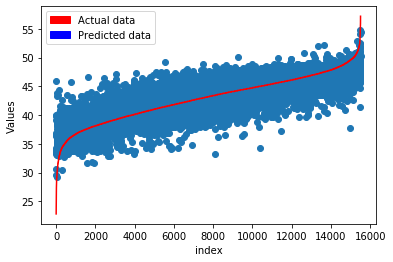

,t + 1,pred (t +1)
7934,54.9,52.592941
4023,55.1,52.447379
8451,55.1,48.542410
1511,55.1,44.723197
10940,55.3,48.717538
2810,55.7,51.024877
14637,55.9,47.028936
1003,56.0,49.859269
3872,56.5,50.221824
9151,57.2,54.446566


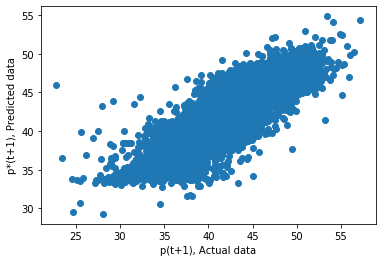

In [17]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

xg boost
==========

In [18]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [19]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 4.915491885694298
root mean_squared_error 2.217090860946907
mean_absolute_error 1.7113147466508156
r2_score 0.6995952234207257


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)